In [4]:
import glob
base_path = '../p0605/xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))
pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [5]:
label_name = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [6]:
len(pneumonia), len(normal)


(3875, 1341)

In [7]:
import matplotlib.pyplot as plt
import os
test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

../p0605/xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('../p0605/xray_classification_pneumonia/Dataset_compressed', 'train')


In [8]:
# folder name to label
labels = []
for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
image_width = 60
image_height = 60
channels = 3
dataset = np.ndarray(shape=(len(file_path), image_height, image_width, channels),dtype=np.float32)
i=0
for _file in file_path:
    img = load_img(_file)
    img.thumbnail((image_width, image_height))
    x = img_to_array(img)
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


### 데이터 시각화 

In [10]:
import cv2

im0 = cv2.imread(pneumonia[67])
im1 = cv2.imread(normal[67])

im0.shape, im1.shape

((60, 60, 3), (60, 60, 3))

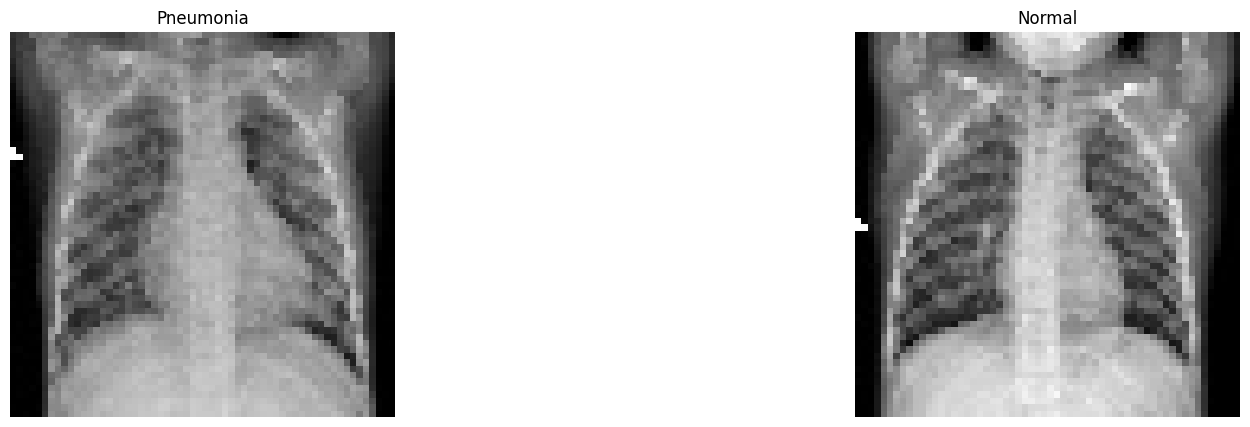

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Pneumonia');plt.imshow(im0);plt.axis('off')
plt.subplot(1,2,2)
plt.title('Normal');plt.imshow(im1),plt.axis('off')
plt.show()

In [12]:
# train, val, test dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train,x_test,y_train,y_test = train_test_split(dataset,labels,test_size=0.2,random_state=321)
x_val, x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state=42)
y_train,y_test,y_val = to_categorical(y_train),to_categorical(y_test),to_categorical(y_val)

# preprocess - normalization => /255.
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_val = x_val.astype('float32')/255.

In [13]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape,x_val.shape,y_val.shape

((4172, 60, 60, 3),
 (4172, 2),
 (522, 60, 60, 3),
 (522, 2),
 (522, 60, 60, 3),
 (522, 2))

### CNN 생성

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [15]:
# Vanilla CNN
def build():
    CNN = Sequential()
    
    CNN.add(Conv2D(32,(3,3),padding='same',input_shape=(60,60,3)))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    CNN.add(Conv2D(64,(3,3),padding='same',activation='relu',))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    CNN.add(Flatten())
    CNN.add(Dense(1000, activation='relu'))
    CNN.add(Dense(500, activation='relu'))
    CNN.add(Dense(2, activation='softmax'))
    
    return CNN
    

In [16]:
# metric function
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(y_pred,0,1)))
    precision = true_positives / (possible_positives + K.epsilon())
    return precision

def f1_m(y_true,y_pred):
    precision = precision_m(y_true,y_pred)
    recall = recall_m(y_true,y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
BATCH_SIZE = 32

### 학습 

In [18]:
CNN_Adam = build()

opt = optimizers.Adam(learning_rate=0.001)

CNN_Adam.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',
               recall_m,
               precision_m,
               f1_m]
)

In [19]:
epochs = 20
history = CNN_Adam.fit(
    x_train,
    y_train,
    validation_data = (x_val,y_val),
    epochs = epochs,
    batch_size = BATCH_SIZE    
)

Epoch 1/20
131/131 [==============================] - 14s 99ms/step - loss: 0.2703 - accuracy: 0.8943 - recall_m: 0.8948 - precision_m: 0.8948 - f1_m: 0.8948 - val_loss: 0.1738 - val_accuracy: 0.9425 - val_recall_m: 0.9449 - val_precision_m: 0.9449 - val_f1_m: 0.9449
Epoch 2/20
131/131 [==============================] - 12s 95ms/step - loss: 0.1013 - accuracy: 0.9619 - recall_m: 0.9621 - precision_m: 0.9621 - f1_m: 0.9621 - val_loss: 0.1134 - val_accuracy: 0.9617 - val_recall_m: 0.9632 - val_precision_m: 0.9632 - val_f1_m: 0.9632
Epoch 3/20
131/131 [==============================] - 13s 96ms/step - loss: 0.0870 - accuracy: 0.9676 - recall_m: 0.9678 - precision_m: 0.9678 - f1_m: 0.9678 - val_loss: 0.1558 - val_accuracy: 0.9425 - val_recall_m: 0.9449 - val_precision_m: 0.9449 - val_f1_m: 0.9449
Epoch 4/20
131/131 [==============================] - 12s 93ms/step - loss: 0.0569 - accuracy: 0.9779 - recall_m: 0.9777 - precision_m: 0.9777 - f1_m: 0.9777 - val_loss: 0.1253 - val_accuracy: 0.9

### 테스트 

In [20]:
score = CNN_Adam.evaluate(x_test,y_test)

17/17 [==============================] - 0s 15ms/step - loss: 0.2626 - accuracy: 0.9732 - recall_m: 0.9743 - precision_m: 0.9743 - f1_m: 0.9743


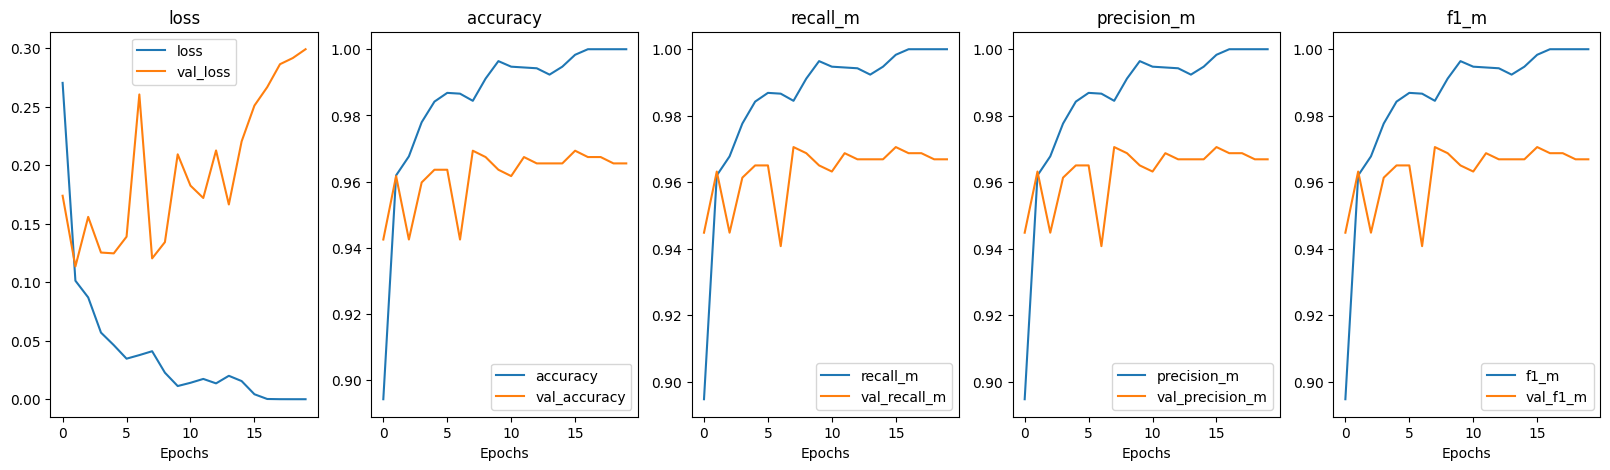

In [21]:
# 시각화
plt.figure(figsize=(20,5))
for i,key in enumerate(list(history.history.keys())[:5]):
    plt.subplot(1,5,i+1)
    plt.title(key)
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel('Epochs')
    plt.legend([key,'val_'+key])
plt.show()

### 예측 

In [22]:
y_pred = CNN_Adam.predict(x_test)

17/17 [==============================] - 0s 15ms/step


In [23]:
y_pred_argmax = np.argmax(np.array(y_pred),axis=1)
y_pred_argmax

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,

In [24]:
# 예측 결과 시각화
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(-1),y_pred_argmax))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       128
           1       0.98      0.98      0.98       394

    accuracy                           0.97       522
   macro avg       0.96      0.97      0.96       522
weighted avg       0.97      0.97      0.97       522



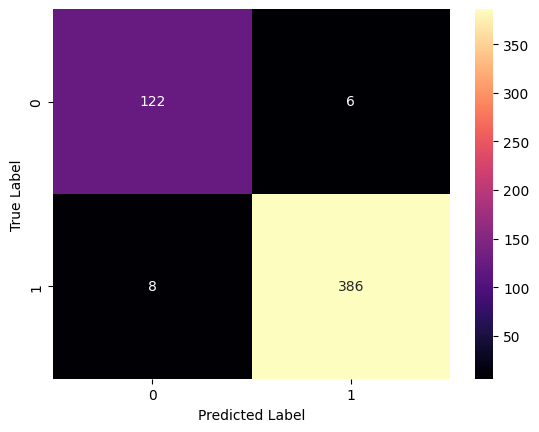

In [25]:
import seaborn as sns 

heatmap = sns.heatmap(confusion_matrix(y_test.argmax(-1),y_pred_argmax),annot=True,fmt='.3g',
                      xticklabels=['0','1'],yticklabels=['0','1'],cmap='magma')
heatmap.set_xlabel('Predicted Label')
heatmap.set_ylabel('True Label')
plt.show()

### Inference 

In [26]:
# 이미지 9개 랜덤 추출
idx = np.random.randint(0, len(x_test),9)

In [27]:
import matplotlib.pyplot as plt
target_x, target_y = x_test[idx],y_test[idx]
predictions = CNN_Adam.predict(target_x)
predictions = predictions.argmax(axis=1)

1/1 [==============================] - 0s 22ms/step


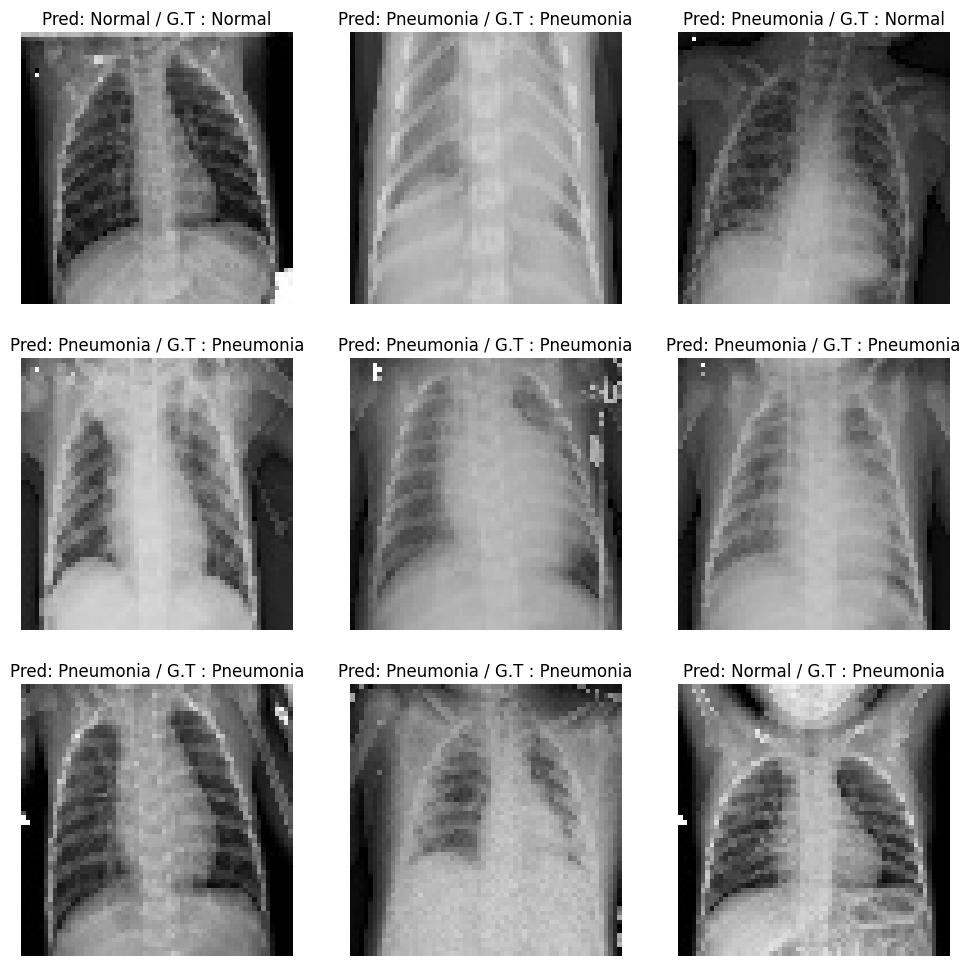

In [28]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred = label_name[predictions[i]]
    gth = label_name[y_test[i].argmax()]
    
    plt.title(f"Pred: {pred} / G.T : {gth}")
    
    plt.imshow(target_x[i])
    plt.axis('off')
    
plt.show()

### CNN with PyTorch 

In [29]:
import torch

# tensor 생성
x = torch.tensor([1., 2., 3.])
print(x)

if torch.cuda.is_available():
    x = x.to('cuda')
    print(x)
else:
    print('unable!')

tensor([1., 2., 3.])
unable!


### 데이터 로드 및 전처리 

In [30]:
import torchvision
import torchvision.transforms as transforms

In [31]:
# 전처리 과정
import torch.utils


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ),(0.5, ))
])

# 데이터셋 로딩
train = torchvision.datasets.MNIST(root='../z20_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train,batch_size=64,shuffle=True)

test = torchvision.datasets.MNIST(root='../z20_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test,batch_size=64,shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../z20_data\MNIST\raw\train-images-idx3-ubyte.gz to ../z20_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../z20_data\MNIST\raw\train-labels-idx1-ubyte.gz to ../z20_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../z20_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../z20_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../z20_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../z20_data\MNIST\raw



### 신경망 모델 

In [33]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self.__init__())
        self.conv1 = nn.Conv2d(1, 6, 5) # 1: 입력채널, 6: 출력 채널, 5: 커널(필터) 크기
        self.pool = nn.MaxPool2d(2, 2) # 2: 커널 크기, 2: 스트라이드(보폭)
        self.conv2 = nn.Conv2d(6, 16, 5) # 6: 입력 채널, 16: 출력 채널, 5: 커널 크기
        self.fc1 = nn.Linear(16*4*4,120) # 16*4*4: 입력, 120: 출력
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)  # flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 모델 생성 

In [ ]:
net = SimpleCNN()